In [12]:
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.fft import get_freq_spectrum
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colorbar import Colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    print(p, '/', l)

G_DIR = (1,0,0) # X direction diffusion gradient
G_CAL = 0.204 # T/m (X gradient calibrated with Utilities/Gradient Calibration.ipynb notebook)
GAMMA = 267.522e6 # rad/s/T

def calc_b_value(par):
    G = G_CAL*np.linalg.norm(par.g_diff, axis=1) # T/m
    d = par.t_diff
    D = par.t_diff_spacing
    b = GAMMA*GAMMA*G*G*d*d*(D-d/3) # s/m^2
    b *= 1e-6 # s/mm^2
    return b

from matipo.util import flint

# modified from IRCPMG_T1T2_spectrum() in ilt.py to use a diffusion kernel function for ADC
def PGSE_CPMG_DT2_spectrum(ADC, T2, b, t_echo, data, alpha=1, **kwargs):
    """
    SRCPMG_T1T2_spectrum: Calculate T1-T2 spectrum from Saturation Recovery CPMG data
    
    Parameters
    ----------
    ADC : float array
        ADC values for the output spectrum
    T2 : float array
        T2 values for the output spectrum
    b : float array
        array of b-values (s/mm^2)
    t_echo : float or float array
        scalar echo spacing or array of echo times (seconds)
    data : 2D float or complex float array
        2D array of PGSE_CPMG data, shape (number of b-values, number of echos).
        The real part after autophasing will be used if complex.
    """
    
    N1, N2 = data.shape
    if len(b) != N1:
        raise Exception(f'size of b ({len(b)} must match axis 0 of data ({N1}))')
    if np.isscalar(t_echo):
        t_echo = np.linspace(0, N2*t_echo, N2, endpoint=False)
    if len(t_echo) != N2:
        raise Exception(f'size of t_echo ({len(t_echo)} must match axis 1 of data ({N2}))')
    
    if np.any(np.iscomplex(data)):
        # autophase using first 2 points
        phase = np.angle(np.mean(data[0][:2]))
        y = np.real(data * np.exp(1j*-phase))
    else:
        y = data.copy()
    
    K1 = np.exp(-np.outer(b, ADC)) # ADC Kernel
    K2 = np.exp(-np.outer(t_echo, 1/T2)) # T2 Kernel
    S, res = flint.flint(K1, K2, y, alpha, **kwargs)
    return S

##### PGSE CPMG Pulse Sequence
90 pulse | delay 1 | `g_diff` gradient for `t_diff` | delay 2 | 180 pulse | delay 3 | `g_diff` gradient for `t_diff` | delay 4 | `n_echo` * (180 pulse | `t_echo`)  | `t_end`

Delays 1-4 are automatically calculated to achieve the spacing between diffusion gradient pulses, `t_diff_spacing`, which is measured between their centres. The echo time of the first echo is also determined automatically.

Acquisitions are centred between 180 pulses in the CPMG readout portion of the pulse sequence (`n_echo` * (180 pulse | `t_echo`)).

In [23]:
# set save directory and base file name
SAVE_DIR = '/home/data/PGSE_CPMG/'
SAVE_NAME = 'shim_sample'

# make the save directory if it doesn't exist
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

In [51]:
# load pulse sequence
seq = Sequence('PGSE_CPMG.py')

# load relevant global variables
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')
seq.loadpar(GLOBALS_DIR+'shims.yaml')

n_b = 20
b_min = 10
b_max = 10000
b = np.logspace(np.log10(b_min), np.log10(b_max), n_b)
d = 20e-3
D = 21e-3
g_diff = np.outer(np.sqrt(1e6*b/(GAMMA*GAMMA*d*d*(D-d/3)))/G_CAL, np.array(G_DIR))
g_diff

# set some parameters directly (SI units)
seq.setpar(
    n_scans=2,
    n_echo=5000,
    t_echo=200e-6,
    n_samples=16,
    t_dw=5e-6,
    t_end=1, # increase for samples with longer T1/T2
    g_diff = g_diff,
    t_diff = d,
    t_diff_spacing = D
)

# print out the parameter set for reference
print(seq.par)

# run sequence, progress_handler is optional
y = await seq.run(progress_handler=print_progress)

# average the echos to get the integrated echo decay curve
y = np.reshape(np.mean(np.reshape(seq.data, (-1, seq.par.n_samples)), axis=1), (-1, seq.par.n_echo))

# correct phase assuming largest (first, using reverse order) recovery time has 0 phase
phase = np.angle(np.mean(y[0][:2]))
y *= np.exp(1j*-phase)

# save 2D data array in numpy format
np.save(f'{SAVE_DIR}/{SAVE_NAME}', y)
seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}.yaml')

ParameterSet(n_scans=2, f=13905077.999697374, a_90=0.28830683329892415, t_90=3.2e-05, a_180=0.5881088470808695, t_180=3.2e-05, t_dw=5e-06, n_samples=16, n_echo=5000, t_echo=0.0002, t_end=1.0, g_diff=array([[0.02419952, 0.        , 0.        ],
       [0.02902379, 0.        , 0.        ],
       [0.0348098 , 0.        , 0.        ],
       [0.04174927, 0.        , 0.        ],
       [0.05007215, 0.        , 0.        ],
       [0.06005423, 0.        , 0.        ],
       [0.07202627, 0.        , 0.        ],
       [0.086385  , 0.        , 0.        ],
       [0.10360618, 0.        , 0.        ],
       [0.12426049, 0.        , 0.        ],
       [0.1490323 , 0.        , 0.        ],
       [0.17874248, 0.        , 0.        ],
       [0.2143755 , 0.        , 0.        ],
       [0.2571121 , 0.        , 0.        ],
       [0.30836842, 0.        , 0.        ],
       [0.36984288, 0.        , 0.        ],
       [0.44357252, 0.        , 0.        ],
       [0.53200045, 0.        , 0.  

In [52]:
# make x axes
g_diff_mag = G_CAL*np.linalg.norm(seq.par.g_diff, axis=1)
t_cpmg = np.linspace(0, seq.par.n_echo*seq.par.t_echo, seq.par.n_echo)
b = calc_b_value(seq.par)

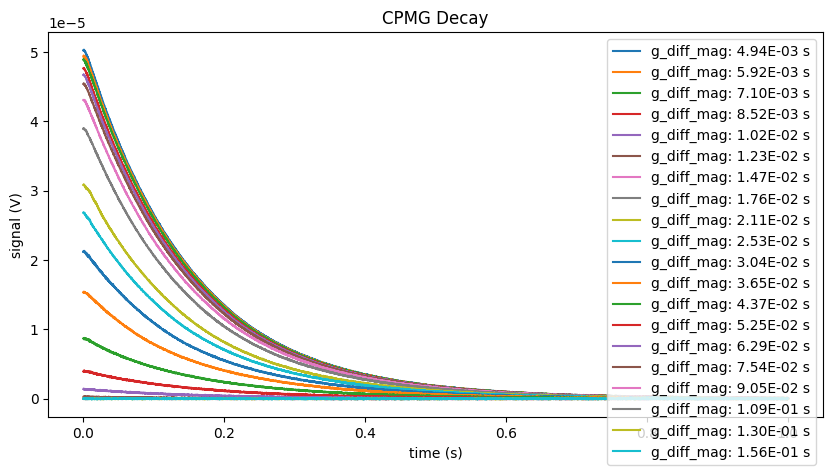

In [53]:
plt.figure(figsize=(10, 5), dpi=100)
for i, g in enumerate(g_diff_mag):
    plt.plot(t_cpmg, y[i].real, label=f'g_diff_mag: {g:.2E} s')
plt.ylabel('signal (V)')
plt.xlabel('time (s)')
plt.title('CPMG Decay')
plt.legend(loc='upper right')
plt.show()

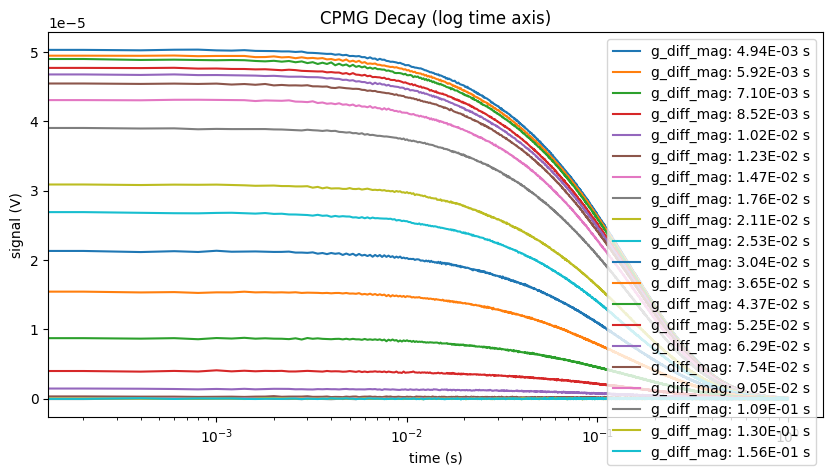

In [54]:
plt.figure(figsize=(10, 5), dpi=100)
for i, g in enumerate(g_diff_mag):
    plt.semilogx(t_cpmg, y[i].real, label=f'g_diff_mag: {g:.2E} s')
plt.ylabel('signal (V)')
plt.xlabel('time (s)')
plt.title('CPMG Decay (log time axis)')
plt.legend(loc='upper right')
plt.show()

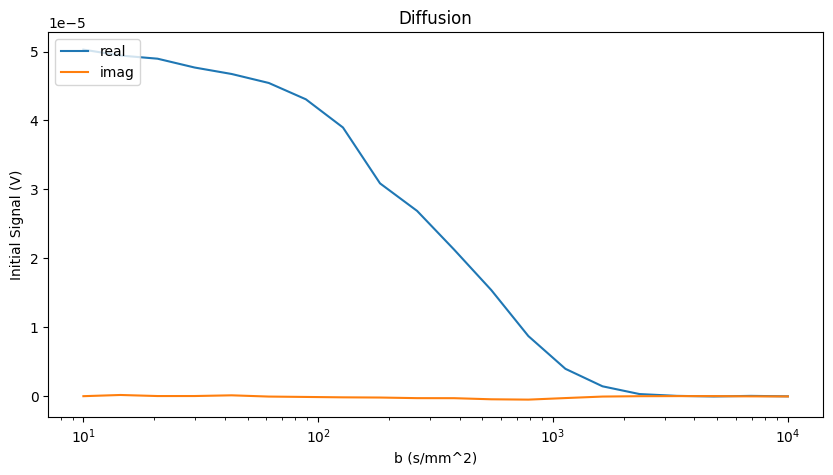

In [55]:
# average first 2 points to get initial signal
plt.figure(figsize=(10, 5), dpi=100)
plt.semilogx(b, np.mean(y.real[:,:2], axis=1), label='real')
plt.semilogx(b, np.mean(y.imag[:,:2], axis=1), label='imag')
plt.ylabel('Initial Signal (V)')
plt.xlabel('b (s/mm^2)')
plt.title('Diffusion')
plt.legend(loc='upper left')
plt.show()

In [56]:
# fit initial signal to e^(-bD) model to calculate ADC value
from scipy.optimize import curve_fit
from scipy.stats import t
def exp_func(x, S0, D):
    return S0 * np.exp(-D * x)

y_diff = np.mean(y.real[:,:2], axis=1)

popt, pcov = curve_fit(exp_func, 1e-3*b, y_diff)
SE = np.sqrt(np.diag(pcov)) # calculate standard error of fit parameters
CI95 = SE * t.ppf(0.975, df=n_b-2) # use t test to get 95% CIs
print(f'ADC = {popt[1]:.3f}±{CI95[1]:.3f} μm²/ms (95% CI)')

ADC = 2.334±0.118 μm²/ms (95% CI)


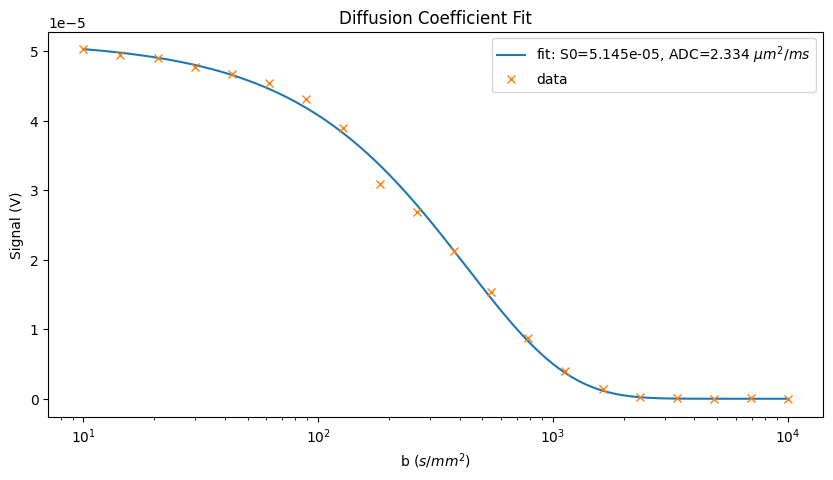

In [57]:
# average first 2 points to get initial signal
plt.figure(figsize=(10, 5), dpi=100)
b_fit = np.logspace(np.log10(b_min), np.log10(b_max), 1000) # generate b values for a smooth fit curve
plt.semilogx(b_fit, exp_func(1e-3*b_fit, *popt), label='fit: S0=%5.3e, ADC=%5.3f $\mu m^2/ms$' % tuple(popt))
plt.semilogx(b, y_diff, 'x', label='data')
plt.ylabel('Signal (V)')
plt.xlabel('b ($s/mm^2$)')
plt.title('Diffusion Coefficient Fit')
plt.legend()
plt.show()

In [58]:
# Run Inverse Laplace Transform
n_ADC = 20
n_T2 = 20
alpha = 1
ADC = np.logspace(-2,2,n_ADC) # um^2/ms
T2 = np.logspace(-3,1,n_T2)
# using larger tolerance to speed up calculation, for better results
# transfer the data to a PC and run ILT with the default tolerance of 1e-5
S = PGSE_CPMG_DT2_spectrum(ADC, T2, b*1e-3, t_cpmg, y, alpha, tol=1e-3, progress=1000)

Lipschitz constant found: ii=  6, LL=  8.187e+06
      0  1.62e+00  1.00e+00  inf  3.756e+07  2.460e-01
   1000  5.03e+02  2.98e-03  3.923e+06  9.575e+00  9.899e-01
   2000  1.00e+03  1.50e-03  1.110e+01  7.910e-01  9.966e-01
   3000  1.50e+03  9.98e-04  5.354e+00  1.245e-01  9.986e-01
   4000  2.00e+03  7.49e-04  6.353e+00  1.693e-02  9.995e-01
   5000  2.50e+03  5.99e-04  4.942e+01  3.358e-04  9.999e-01
   6000  3.00e+03  4.99e-04  3.932e+04  8.541e-09  1.000e+00
   7000  3.50e+03  4.28e-04  7.404e-02  7.952e-09  1.000e+00
   8000  4.00e+03  3.75e-04  4.661e-03  7.915e-09  1.000e+00
   9000  4.50e+03  3.33e-04  1.103e-02  7.829e-09  1.000e+00
  10000  5.00e+03  3.00e-04  6.082e-03  7.782e-09  1.000e+00
  11000  5.50e+03  2.73e-04  1.900e-03  7.767e-09  1.000e+00
  12000  6.00e+03  2.50e-04 -8.937e-04  7.774e-09  1.000e+00


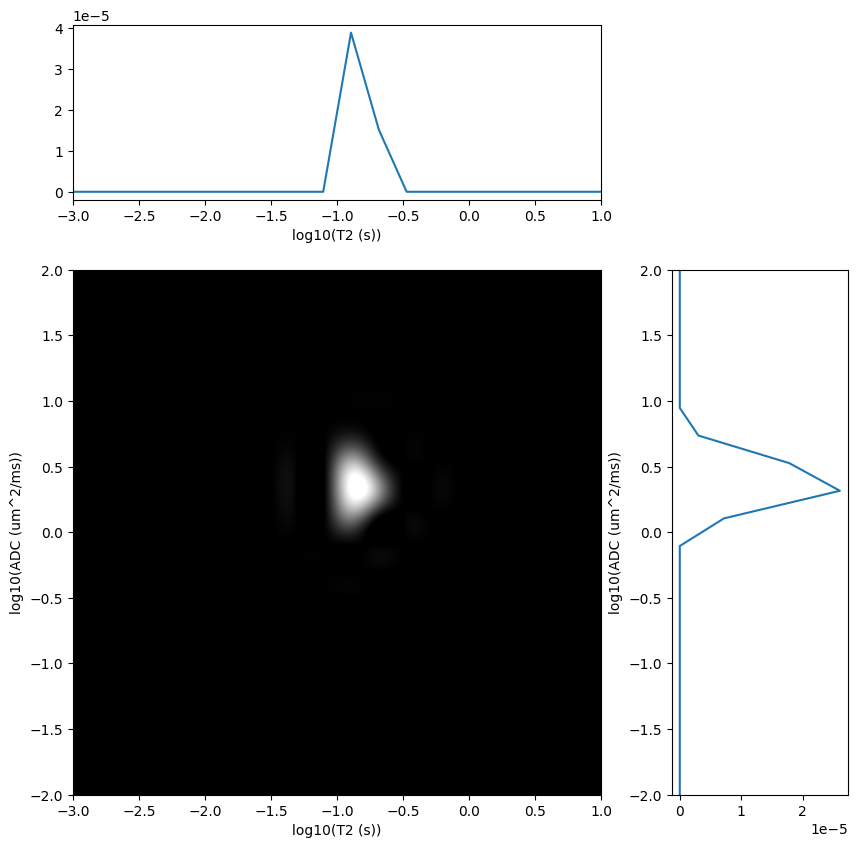

In [59]:
# Plot the 2D ADC-T2 map
x_ = np.log10(T2)
y_ = np.log10(ADC)
x_lim = (x_.min(), x_.max())
y_lim = (y_.min(), y_.max())
fig= plt.figure(figsize=(10,10), dpi=100)
gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])
ax = plt.subplot(gs[1,0])
axr = plt.subplot(gs[1,1], sharey=ax)
axt = plt.subplot(gs[0,0], sharex=ax)
# main plot
ax.imshow(S, origin='lower', extent=x_lim+y_lim, aspect='auto', cmap='gray', interpolation='lanczos')
plt.xlim(x_lim)
ax.set_xlabel('log10(T2 (s))')
ax.set_ylabel('log10(ADC (um^2/ms))')
# T1 projection plot
axr.plot(S.sum(1), y_)
axr.set_ylabel('log10(ADC (um^2/ms))')
# T2 projection plot
axt.plot(x_, S.sum(0))
axt.set_xlabel('log10(T2 (s))')
plt.show()